We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# Overview

We illustrate the numerical implementation and the use of the Finite Time Lyapunov Exponent (FTLE) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional turbulence simulation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{FTLE} $:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
    <br />
    
    * Compute $ \mathrm{FTLE} $ from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0))
    \end{equation}
 <br />    
6. References

# Import data

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 16

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 20 # float

# Time step-size
dt = 0.1 # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# resolution
Nx = 400
Ny = 400

# specify domain over which to compute LCS
x_domain = np.linspace(3, 5, Nx)
y_domain = np.linspace(1, 3, Ny)

# set x-limits
xmin = np.min(x_domain)
xmax = np.max(x_domain)

# set x-limits
ymin = np.min(y_domain)
ymax = np.max(y_domain)

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

# $ \mathrm{FTLE} $

Next, we compute the $ \mathrm{FTLE} $ over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. From the maximum singular value of the gradient of the flow map we can then compute the $ \mathrm{FTLE} $.

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_FTLE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # array (Nt, 2, 2, Nx*Ny)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (Nt, 2, 2, Nx*Ny)

    # Compute FTLE
    FTLE = [] # list (Nx*Ny,)
    for i in range(gradFmap_t0_tN.shape[2]):
        FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))
    
    return FTLE

In [7]:
# compute FTLE
results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_FTLE)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract FTLE from results of parallel computing
FTLE = results[0]

for res in results[1:]:
    FTLE = np.append(FTLE, res)
    
# Reshape array from vectorized form to structured meshgrid
FTLE = FTLE.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:  2.4min remaining: 16.7min
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:  2.5min remaining: 10.7min
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:  2.5min remaining:  7.5min
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:  2.6min remaining:  5.6min
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:  2.6min remaining:  4.4min
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:  2.7min remaining:  3.4min
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:  2.8min remaining:  2.2min
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:  2.9min remaining:  1.7min
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:  2.9min remaining:  1.3min
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapse

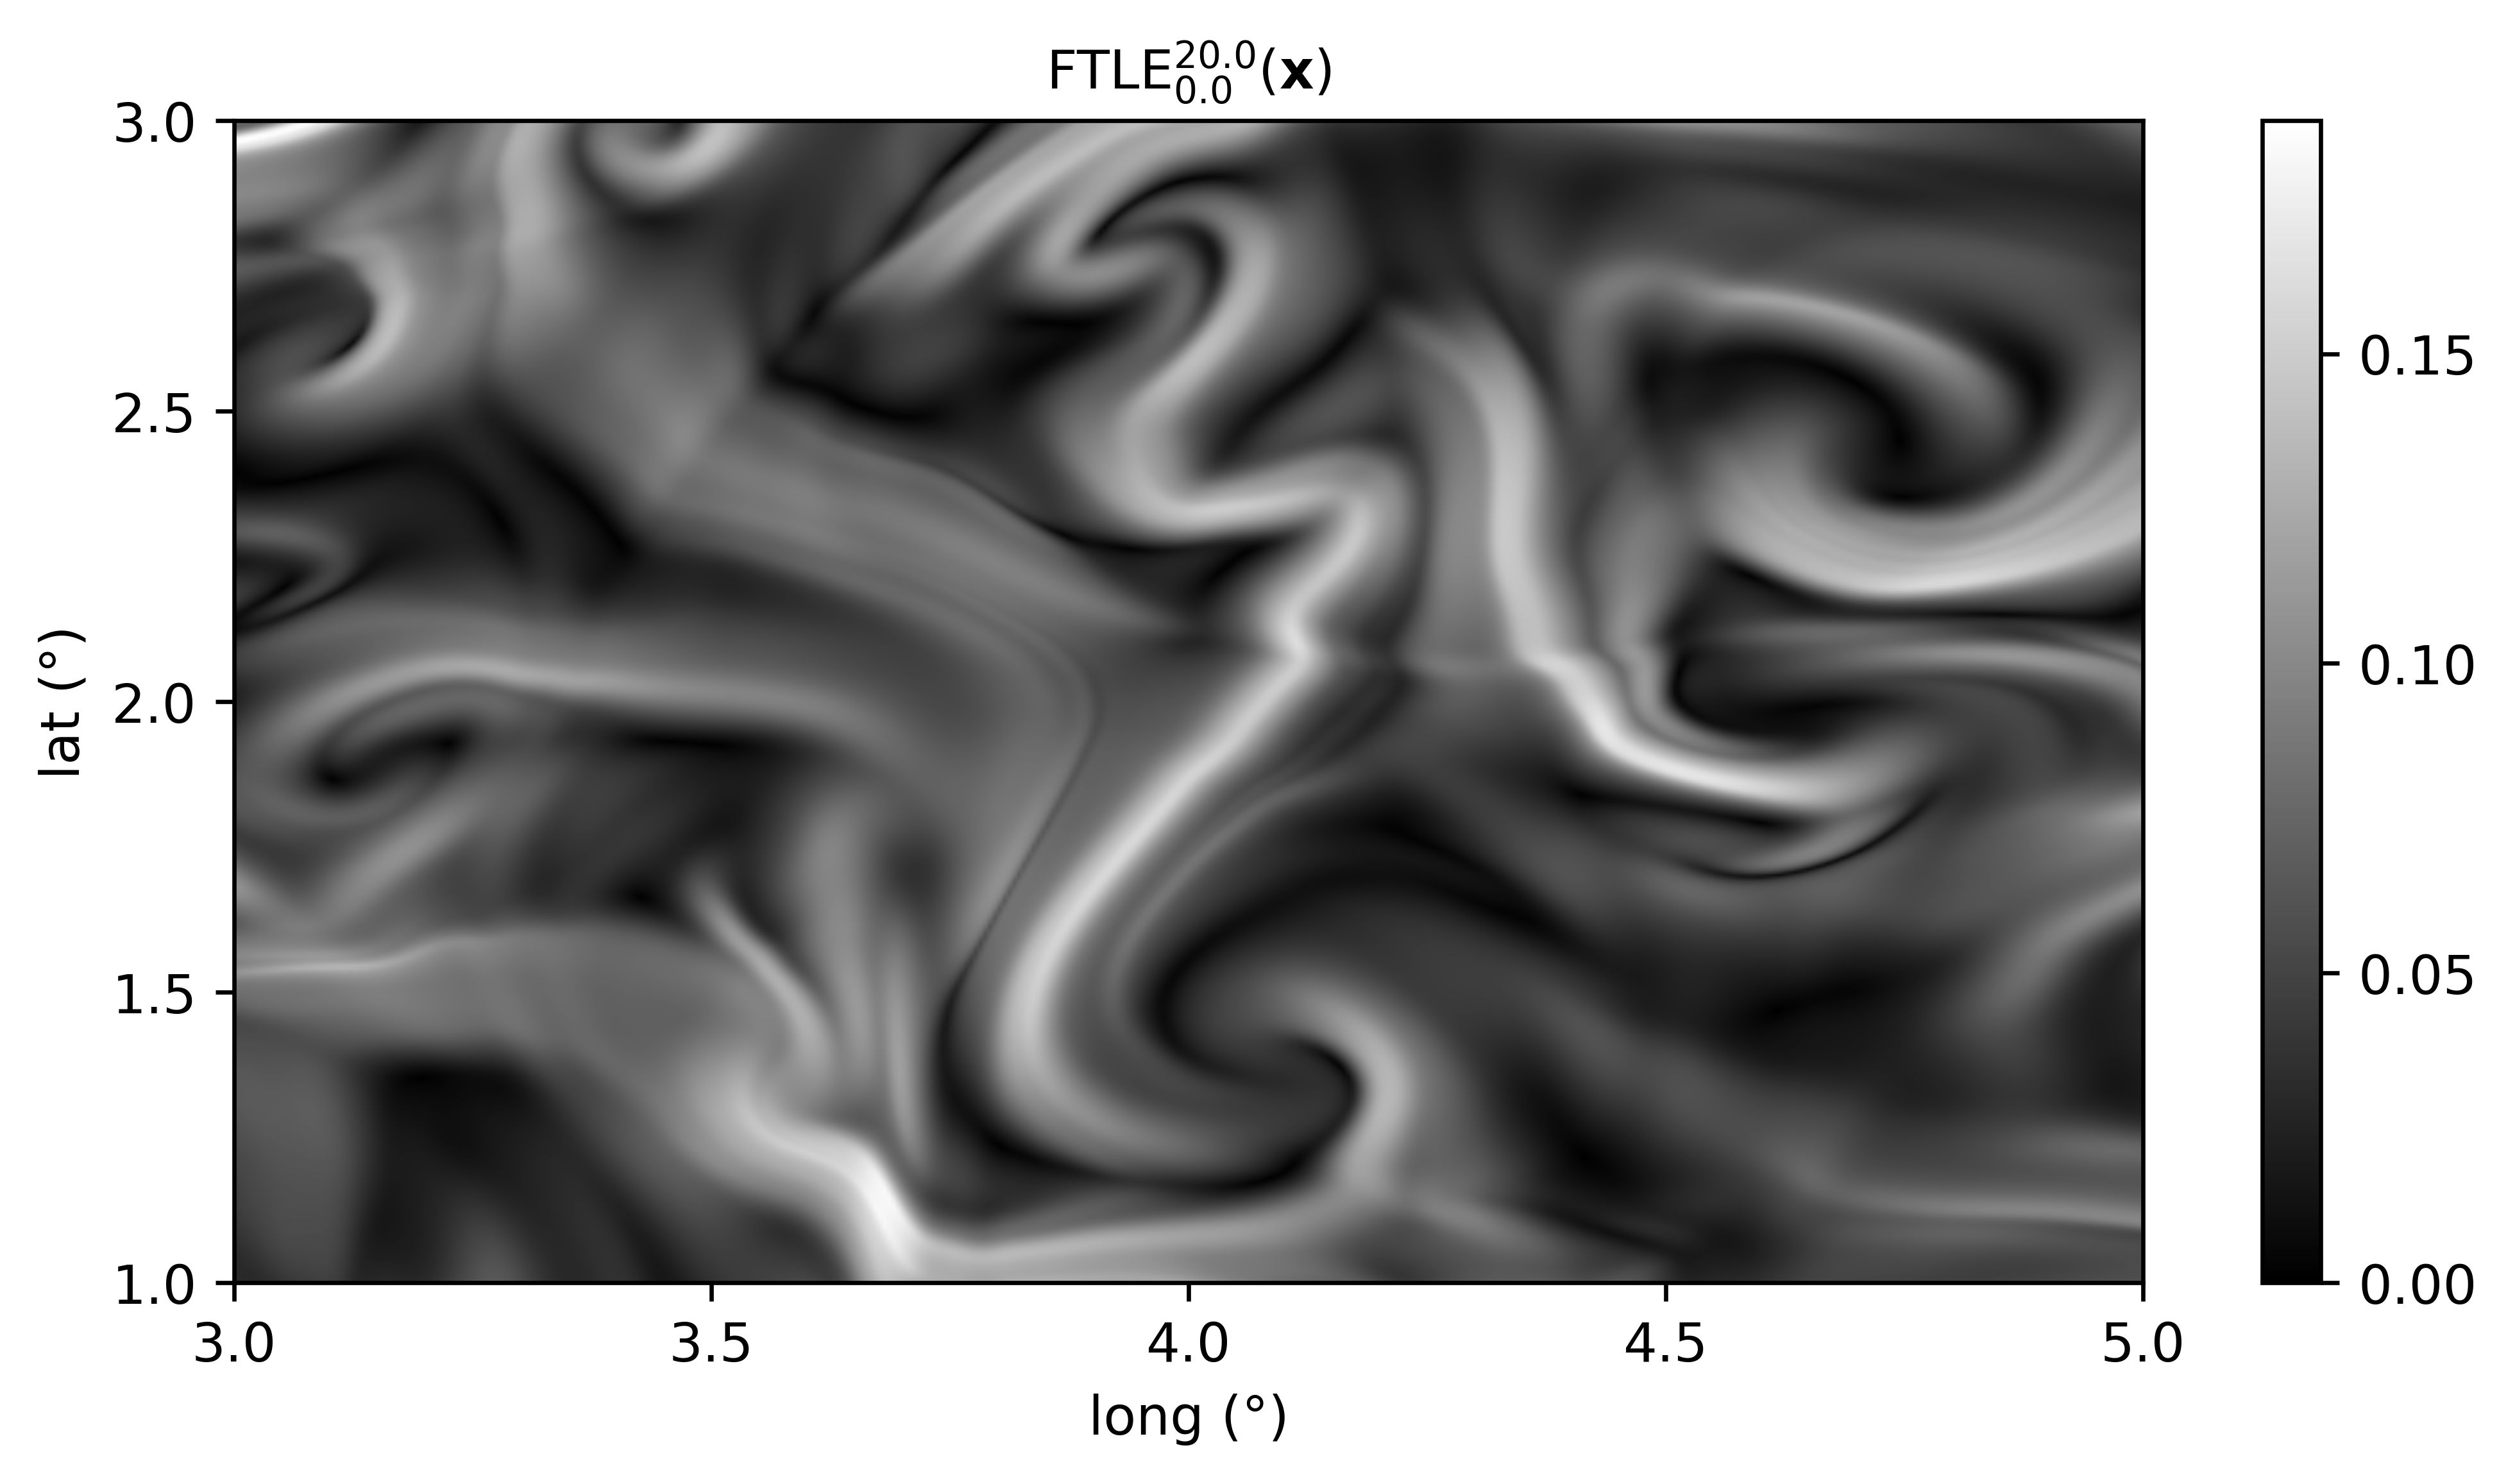

In [8]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of FTLE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(FTLE), cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 0.5))
ax.set_yticks(np.arange(ymin, ymax+0.1, 0.5))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))

# Title
ax.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{np.around(time[0],2)}}}^{{{np.around(time[-1],2)}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

The forward $ \mathrm{FTLE} $ field is plotted with respect to the initial position of the particles. Repelling LCS are visible as ridges in the forward $ \mathrm{FTLE} $ field, whereas trenches of $ \mathrm{FTLE} $ field signal parabolic (jet-type) LCSs. An analogous statement holds for attracting LCS and the backward $ \mathrm{FTLE} $ field. As a first approach, ridges of the $ \mathrm{FTLE} $ field can be extracted using simple thresholding. This should already provide a good hint to the location of hyperbolic features.

$ \mathrm{FTLE} $ ridges, however, are necessary but not sufficient conditions for hyperbolic LCS. Ridges of the $ \mathrm{FTLE} $ field have also been related to regions of high shear. As a consequence the $ \mathrm{FTLE} $ should only be considered as a first (and relatively rapid) approach for finding hyperbolic (repelling/attracting) LCS. More advanced methods such as the computation of the tensorlines associated to the eigenvalues of the Cauchy-Green strain tensor, should be used for a precise computation of hyperbolic LCS (see [HyperbolicLCS](../../HyperbolicLCS/Main/HyperbolicLCSTurbulence.ipynb)).[1, 2].

# References

[1] Haller, G. (2015). Lagrangian coherent structures. Annual Review of Fluid Mechanics, 47, 137-162.

[2] Haller, G., & Sapsis, T. (2011). Lagrangian coherent structures and the smallest finite-time Lyapunov exponent. Chaos: An Interdisciplinary Journal of Nonlinear Science, 21(2), 023115.

[3] Notebook 5.2.3 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.